In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
df = pd.read_json("../data/bronze/prices/spx500_usd_m1_historical.ndjson", lines=True)
df['datetime'] = pd.to_datetime(df['time'])
df['time'] = df['datetime'].dt.time
df['date'] = df['datetime'].dt.date
df['dow'] = df['datetime'].dt.day_name()
df['gap_minutes'] = df['datetime'].diff().dt.total_seconds() / 60
df.head()

,time,instrument,granularity,open,high,low,close,volume,collected_at,datetime,date,dow,gap_minutes
0,12:18:00,SPX500_USD,M1,5829.6,5829.8,5829.6,5829.6,13,2025-10-16 12:18:44.329964+00:00,2024-10-16 12:18:00+00:00,2024-10-16,Wednesday,NaN
1,12:19:00,SPX500_USD,M1,5829.8,5829.8,5829.6,5829.6,13,2025-10-16 12:18:44.330972+00:00,2024-10-16 12:19:00+00:00,2024-10-16,Wednesday,1.0
2,12:20:00,SPX500_USD,M1,5829.0,5829.0,5828.6,5828.8,7,2025-10-16 12:18:44.330972+00:00,2024-10-16 12:20:00+00:00,2024-10-16,Wednesday,1.0
3,12:21:00,SPX500_USD,M1,5828.6,5828.8,5828.0,5828.6,21,2025-10-16 12:18:44.330972+00:00,2024-10-16 12:21:00+00:00,2024-10-16,Wednesday,1.0
4,12:22:00,SPX500_USD,M1,5828.4,5829.2,5828.2,5829.0,22,2025-10-16 12:18:44.330972+00:00,2024-10-16 12:22:00+00:00,2024-10-16,Wednesday,1.0


C:\Users\user\AppData\Local\Temp\ipykernel_43708\3542052008.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adf['first_time'] = pd.to_datetime(adf['first_time'].astype(str))
C:\Users\user\AppData\Local\Temp\ipykernel_43708\3542052008.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adf['last_time'] = pd.to_datetime(adf['last_time'].astype(str))


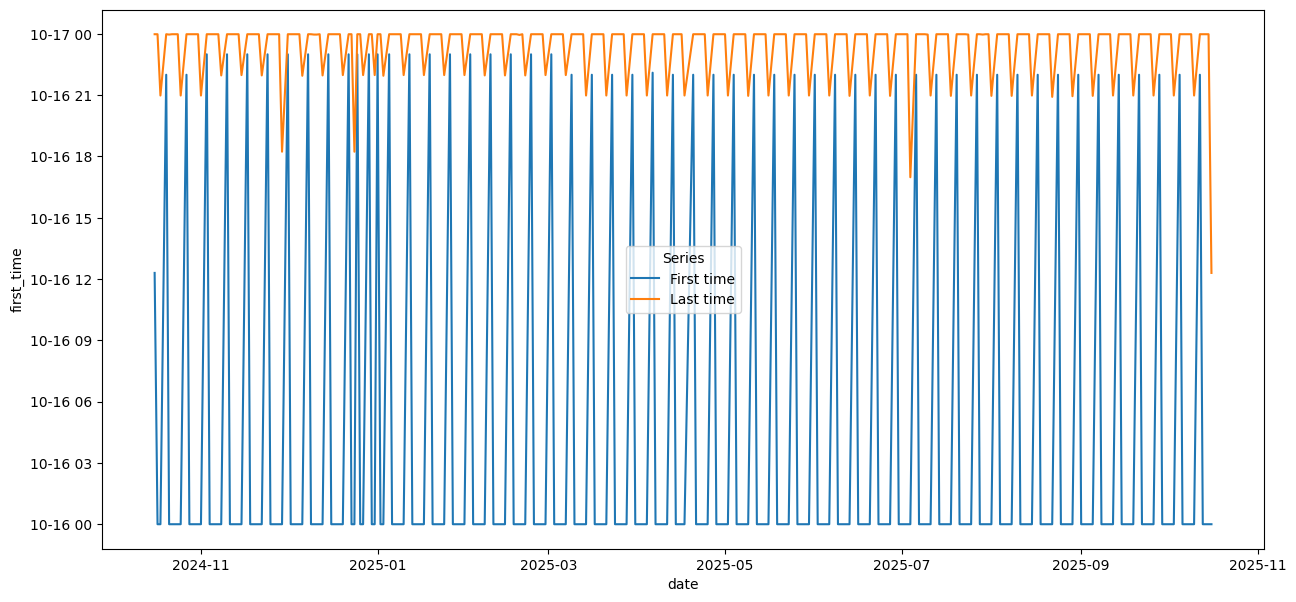

In [32]:
adf = df.groupby(['date', 'dow']).agg(first_time=('time', 'first'), last_time=('time', 'last')).reset_index()
adf['first_time'] = pd.to_datetime(adf['first_time'].astype(str))
adf['last_time'] = pd.to_datetime(adf['last_time'].astype(str))
fig,ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=adf, x='date', y='first_time', ax=ax, label='First time')
sns.lineplot(data=adf, x='date', y='last_time', ax=ax, label='Last time')
ax.legend(title='Series', loc='best')

<Axes: xlabel='datetime', ylabel='gap_minutes'>

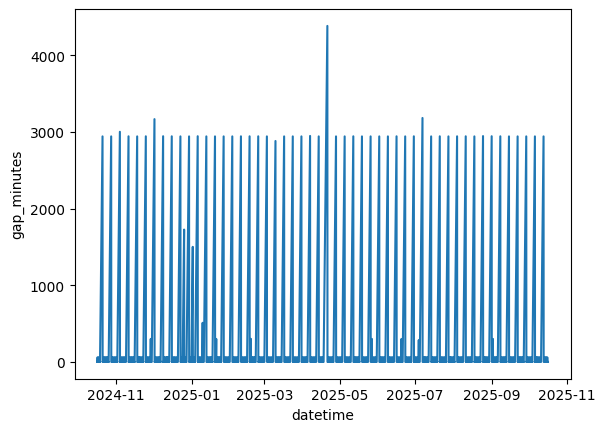

In [52]:
sns.lineplot(df, x='datetime', y='gap_minutes')

<Axes: xlabel='gap_minutes', ylabel='Count'>

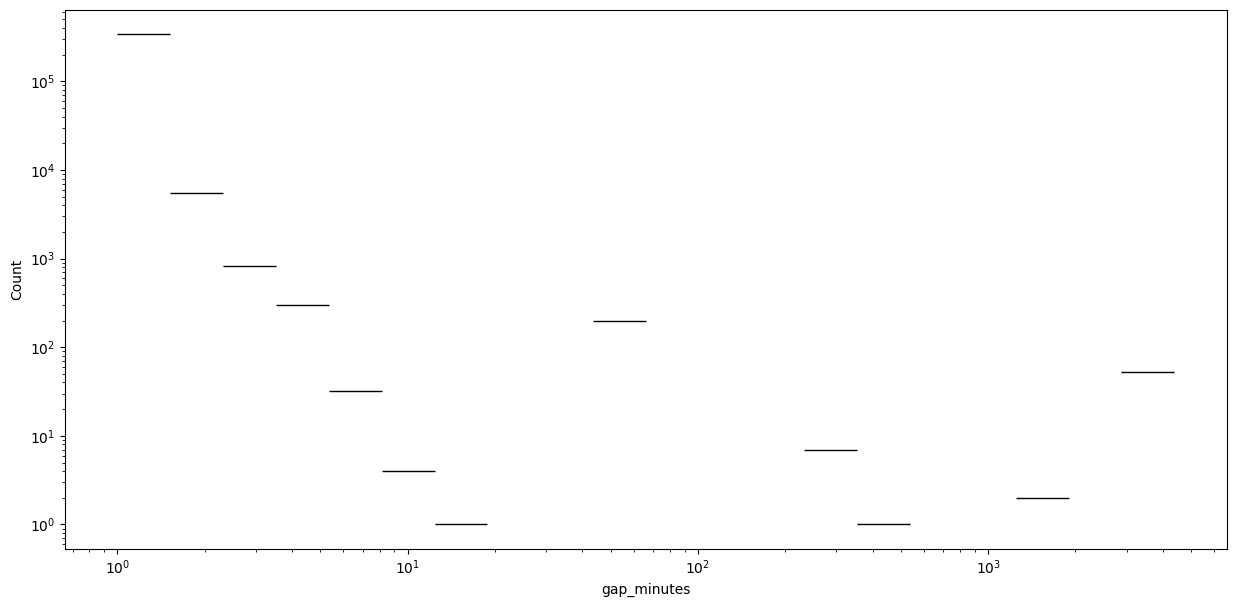

In [50]:
fig,ax = plt.subplots(figsize=(15,7))
sns.histplot(df['gap_minutes'].dropna(), fill=True, ax=ax, log_scale=(True,True))

In [5]:
df[df['open'].isna()]

,time,instrument,granularity,open,high,low,close,volume,collected_at,date


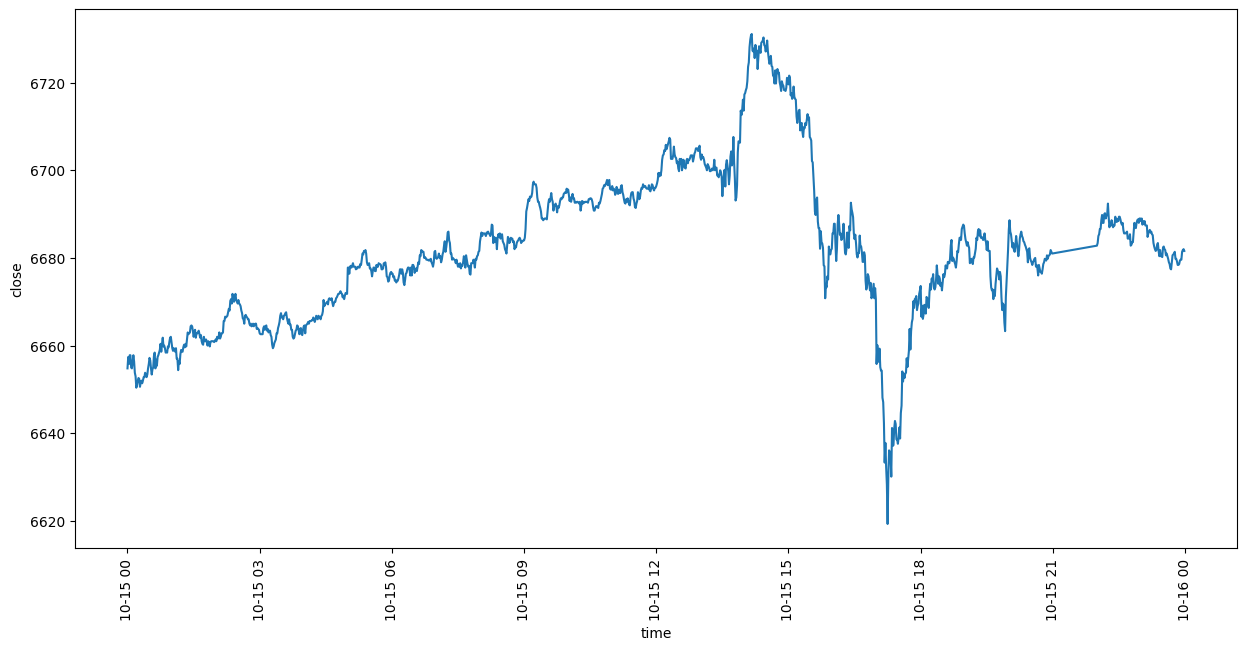

In [ ]:
fig,ax = plt.subplots(figsize=(15,7))
sns.lineplot(df[df['date'] == pd.to_datetime('2025-10-15').date()], x='time', y='close')
ax.tick_params(axis='x', rotation=90)

In [3]:
# --- Step 1: Prepare ---
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df = df.sort_values(['instrument', 'time'])

# --- Step 2: Function to fill within date boundaries ---
def fill_within_day(g):
    if len(g) < 2:
        return g  # skip days with only 1 record
    start, end = g['time'].min(), g['time'].max()
    full_range = pd.date_range(start=start, end=end, freq='1min')
    g = g.set_index('time').reindex(full_range)
    g.index.name = 'time'
    g['date'] = g['date'].iloc[0]  # restore date
    g['instrument'] = g['instrument'].iloc[0]
    return g.reset_index()

# --- Step 3: Apply per instrument and per date ---
df = (
    df.groupby(['instrument', 'date'], group_keys=False)
      .apply(fill_within_day)
      .reset_index(drop=True)
)

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute

C:\Users\user\AppData\Local\Temp\ipykernel_43708\2615850230.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['instrument', 'date'], group_keys=False)
